In [9]:
!/apps/share64/debian10/anaconda/anaconda-7/envs/AIIDA/bin/verdi presto --profile-name fair-workflows

Report: Option `--use-postgres` not enabled: configuring the profile to use SQLite.
Report: RabbitMQ server not found (Failed to connect with following connection parameters: {'protocol': 'amqp', 'username': 'guest', 'password': 'guest', 'host': '127.0.0.1', 'port': 5672, 'virtual_host': ''}): configuring the profile without a broker.
Report: Initialising the storage backend.
Report: Storage initialisation completed.
Success: Created new profile `fair-workflows`.
Success: Configured the localhost as a computer.


In [11]:
!verdi status # This points to system, one would either have to define an alias or add it to PATH

/bin/bash: verdi: command not found


In [10]:
%load_ext aiida
%aiida

The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


In [12]:
%verdi status

 ✔ version:     AiiDA v2.6.1
 ✔ config:      /home/nanohub/jgeiger/.aiida
 ✔ profile:     fair-workflows
 ✔ storage:     SqliteDosStorage[/home/nanohub/jgeiger/.aiida/repository/sqlite_dos_be1820e15acc4f319de2f6331f64b2d0]: open,
 ⏺ broker:      No broker defined for this profile: certain functionality not available.
 ⏺ daemon:      No broker defined for this profile: daemon is not available.


In [ ]:
%verdi storage info

In [25]:
!/apps/share64/debian10/anaconda/anaconda-7/envs/AIIDA/bin/aiida-pseudo install sssp -x PBE -p efficiency
!/apps/share64/debian10/anaconda/anaconda-7/envs/AIIDA/bin/aiida-pseudo install sssp -x PBEsol -p efficiency

Report: downloading patch versions information...  [OK]
Report: downloading selected pseudopotentials archive...  [OK]
Report: downloading selected pseudopotentials metadata...  [OK]
Report: unpacking archive and parsing pseudos...  [OK]
Success: installed `SSSP/1.3/PBE/efficiency` containing 103 pseudopotentials.
Report: downloading patch versions information...  [OK]
Report: downloading selected pseudopotentials archive...  [OK]
Report: downloading selected pseudopotentials metadata...  [OK]
Report: unpacking archive and parsing pseudos...  [OK]
Success: installed `SSSP/1.3/PBEsol/efficiency` containing 103 pseudopotentials.


In [26]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 1
  Nodes:
    count: 207
  Groups:
    count: 2
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 0
repository:
  SHA-hash algorithm: sha256
  Compression algorithm: zlib+1
  Objects:
    packed: 0
    loose: 206
    pack_files: 0



In [23]:
from aiida import engine, orm
from aiida_quantumespresso.calculations.pw import PwCalculation
from ase.build import bulk

In [51]:
# %verdi code delete 'qe-7.1-pw' --force

Report: 8 Node(s) marked for deletion
Report: Starting node deletion...
Report: Deletion of nodes completed.
Success: Finished deletion.


In [49]:
qe_code = orm.InstalledCode(
    append_text='',
    computer=orm.load_computer('localhost'),
    default_calc_job_plugin='quantumespresso.pw',
    description='',
    filepath_executable='/apps/share64/debian10/espresso/espresso-7.1/bin/pw.x',
    label='qe-7.1-pw',
    prepend_text='export OMP_NUM_THREADS=1',
    use_double_quotes=False,
    with_mpi= False
).store()

In [52]:
%verdi code list
%verdi code test 'qe-7.1-pw'

Full label             Pk  Entry point
-------------------  ----  -------------------
qe-7.1-pw@localhost   241  core.code.installed

Use `verdi code show IDENTIFIER` to see details for a code
Success: all tests succeeded.


In [53]:
scf_inputs = {
    'CONTROL': {
        'calculation': 'scf',
        # 'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1,
}

@engine.calcfunction
def rescale_list(structure: orm.StructureData, factor_list: orm.List):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        ase_structure = structure.get_ase()

        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

@engine.calcfunction
def create_eos_dictionary(**kwargs) -> orm.Dict:
    eos = {
        label: (result['volume'], result['energy'])
        for label, result in kwargs.items()
    }
    return orm.Dict(eos)

class EquationOfStateWorkChain(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)

        spec.outline(
            cls.run_eos,
            cls.results,
        )
        spec.output("eos_dict", valid_type=orm.Dict)

    def run_eos(self):

        calcjob_dict = {}

        for label, rescaled_structure in rescale_list(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwCalculation.get_builder()
            builder.code = self.inputs.code
            builder.structure = rescaled_structure
            builder.parameters = orm.Dict(scf_inputs)
            pseudo_family = orm.load_group('SSSP/1.3/PBEsol/efficiency')
            builder.pseudos = pseudo_family.get_pseudos(structure=rescaled_structure)
            kpoints = orm.KpointsData()
            kpoints.set_kpoints_mesh([2, 2, 2])
            builder.kpoints = kpoints
            builder.metadata.options.resources = resources

            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        return calcjob_dict

    def results(self):

        self.report(self.ctx)

        # label: self.ctx[label].outputs['properties'] for label in self.ctx.labels

        eos_results = {}
        for label in self.ctx.labels:
            energy = self.ctx[label].outputs.output_parameters.get_dict()['energy']
            volume = self.ctx[label].outputs.output_parameters.get_dict()['volume']
            eos_results[label] = orm.Dict({'energy': orm.Float(energy), 'volume': orm.Float(volume)})
        # }
        eos_dict = create_eos_dictionary(**eos_results)
        self.out('eos_dict', eos_dict)


In [54]:
structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))

results = engine.run(
    EquationOfState,
    code=orm.load_code("qe-7.1-pw@localhost"),
    structure=structure,
    scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]),
)

Report: [244|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: ba67f047-9f82-467b-b9d7-97fd99a49df6 (pk: 253) (aiida.calculations:quantumespresso.pw)>, 'structure_1': <CalcJobNode: uuid: 09bba60b-fa1f-4dbd-919b-e4909abde28c (pk: 256) (aiida.calculations:quantumespresso.pw)>, 'structure_2': <CalcJobNode: uuid: c6b09777-cdd7-4eb5-b4c4-6184d3dacb1a (pk: 259) (aiida.calculations:quantumespresso.pw)>, 'structure_3': <CalcJobNode: uuid: 7b358f87-1929-4805-a91b-cc2e4f108142 (pk: 262) (aiida.calculations:quantumespresso.pw)>, 'structure_4': <CalcJobNode: uuid: f64bb55d-82ce-4bd8-81db-0ebca8883877 (pk: 265) (aiida.calculations:quantumespresso.pw)>})


In [55]:
%verdi process list -ap 1

  PK  Created    Process label          ♻    Process State    Process status
----  ---------  ---------------------  ---  ---------------  ----------------
 244  59s ago    EquationOfState             ⏹ Finished [0]
 245  58s ago    rescale_list                ⏹ Finished [0]
 253  57s ago    PwCalculation               ⏹ Finished [0]
 256  55s ago    PwCalculation               ⏹ Finished [0]
 259  54s ago    PwCalculation               ⏹ Finished [0]
 262  53s ago    PwCalculation               ⏹ Finished [0]
 265  52s ago    PwCalculation               ⏹ Finished [0]
 296  14s ago    create_eos_dictionary       ⏹ Finished [0]

Total results: 8

Report: ♻ Processes marked with check-mark were not run but taken from the cache.
Report: Add the option `-P pk cached_from` to the command to display cache source.
Report: Last time an entry changed state: 13s ago (at 08:35:38 on 2024-08-06)


In [58]:
%verdi process show 253

Property     Value
-----------  ------------------------------------
type         PwCalculation
state        Finished [0]
pk           253
uuid         ba67f047-9f82-467b-b9d7-97fd99a49df6
label
description
ctime        2024-08-06 08:34:55.396695+00:00
mtime        2024-08-06 08:35:25.389799+00:00
computer     [1] localhost

Inputs      PK    Type
----------  ----  -------------
pseudos
    Al      172   UpfData
code        241   InstalledCode
kpoints     252   KpointsData
parameters  251   Dict
structure   246   StructureData

Outputs              PK  Type
-----------------  ----  --------------
output_band         275  BandsData
output_parameters   277  Dict
output_trajectory   276  TrajectoryData
remote_folder       266  RemoteData
retrieved           271  FolderData

Caller      PK  Type
--------  ----  ---------------
CALL       244  EquationOfState


In [59]:
%verdi process report 253

*** 253: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


In [60]:
%verdi calcjob outputcat 253

AttributeError: 'OutStream' object has no attribute 'buffer'

In [61]:
calcjob = orm.load_node(253)
retrieved = calcjob.outputs.retrieved
path = calcjob.get_option('input_filename')
with retrieved.base.repository.open(path, mode='rb') as fhandle:
    file_contents = fhandle.read()
print(file_contents.decode('utf-8'))

FileNotFoundError: object with path `aiida.in` does not exist.

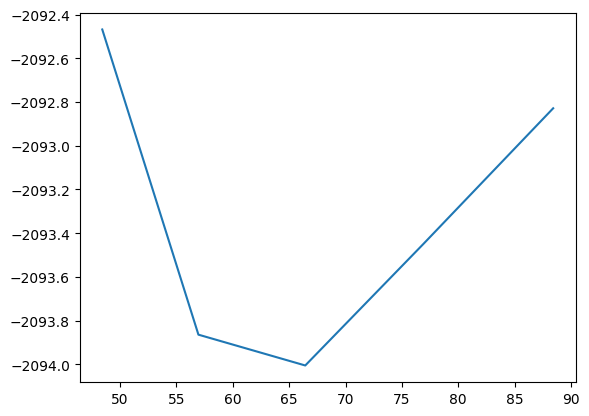

In [63]:
from matplotlib import pyplot as plt

eos_dict = results['eos_dict'].get_dict()

plt.plot(
    [e[0] for e in eos_dict.values()],
    [v[1] for v in eos_dict.values()],
)